{
  'id': 42953,
  'img': 'img/42953.png',
  'label': 0,
  'text': 'its their character not their color that matters'
}




In [1]:
import cv2
import random
import tensorflow as tf
from sklearn.neighbors import KDTree

import PIL
import numpy as np
import json

DATASET_PATH = '/home/jafar/Downloads/data'
    
FILE_JSON = DATASET_PATH + '/train.jsonl'

print('getting keras feature extractor')

base_model = tf.keras.applications.EfficientNetB1(input_shape=(224,224,3),include_top=False)

base_model.trainable = False

inp = tf.keras.layers.Input((224,224,3))

x = base_model(inp)

base_model = tf.keras.Model(inp, x)


print('loading database, it might take a while, it is 4.2GBs')
images = np.load('./DataCleaner/extracted_features.npy')

print('Creating indexer')
indexer = KDTree(images)

def get_indexes():
    images_annotations = open(FILE_JSON).readlines()
    nigg = {}
    s = set()
    text_index = []
    for row in images_annotations:

        traindict = json.loads(row)
        if not traindict['id'] in nigg:
            nigg[traindict['id']] = []
        nigg[traindict['id']].append({'text':traindict['text'],'img':traindict['img']})
        text_index.append(traindict['id'])
    return text_index, nigg


text_index, nigg = get_indexes()

def predeploy():
    ## pre-deployment    
    
    images = np.zeros((8500,7,7,1280),np.float64)
    for cnt, k in enumerate(nigg.keys()):
        zbr = PIL.Image.open(DATASET_PATH+'/'+nigg[k][0]['img'])
        zbr.thumbnail((224,224))
        zbr = np.array(zbr)
        if zbr.shape[2] == 4:
            continue
        result = np.zeros((224,224,3))
        result[:zbr.shape[0],:zbr.shape[1]] = zbr
        result= result.reshape((1,224,224,3))

        images[cnt] = base_model.predict(result)
        if cnt % 50 == 0:
            print(cnt)
    images = images.reshape(8500,7*7*1280)
    # np.save('extracted_features', images)



getting keras feature extractor
loading database, it might take a while, it is 4.2GBs
Creating indexer


Processing image
choice is 4003
gays on their way home after pride week
Shape (112, 224, 3)


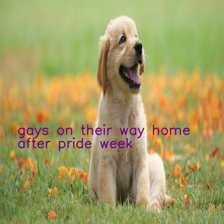

In [103]:
from DataCleaner.Extractor import get_vector, image2np, read_image

def process_image(path):

    K = 5
    
    
    # put text on image

    im = np.array(read_image(path))

    font = cv2.FONT_HERSHEY_SIMPLEX
    imcopy = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_AREA)
    imcopy = image2np(imcopy)

    img = get_vector(imcopy.reshape((1, 224, 224, 3)))
    textr = ''
    _, choices = indexer.query(img,k=K)
    choices = choices[0]
    choice = random.choice(choices)
    print('choice is', choice)
    text = nigg[text_index[choice]][0]['text']
    if len(im.shape) == 2:
        X, Y = im.shape
    else:
        X, Y, _ = im.shape[:3]
    
    print(text)
    print('Shape', im.shape)
    
    im = cv2.imread(path, 1)

    N = len(text.split(' '))
    lines = 0
    im = cv2.resize(im, dsize=(1000,1000), interpolation = cv2.INTER_AREA)
    X, Y = 1000, 1000
    for cnt,c in enumerate(text.split(' ')):
        

        textr+=c + ' '
        if (cnt % 4 == 0 and cnt != 0) or cnt == N-1:
            cv2.putText(im, textr, (77,X - 400 + lines * 59), font, 2, (123,0, 123), 4, cv2.LINE_AA)
            textr = ''
            lines += 1

    cv2.imwrite(f'./generated/{choice}.jpg', im)
    

    
    return f'./generated/{choice}.jpg'
print('Processing image')
read_image(process_image('./test/1.jpg'))


In [35]:
images.shape



(8500, 62720)

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(images)

PCA(n_components=2)

In [59]:
zbr = pca.transform(images)
zbr.shape

(8500, 2)

In [13]:
z = read_image('/home/jafar/Downloads/data/img/42953.png')
z = np.array(z)
z.shape

(224, 148, 3)

[12.91805918 13.99159684] [12.91805918 13.99159684]


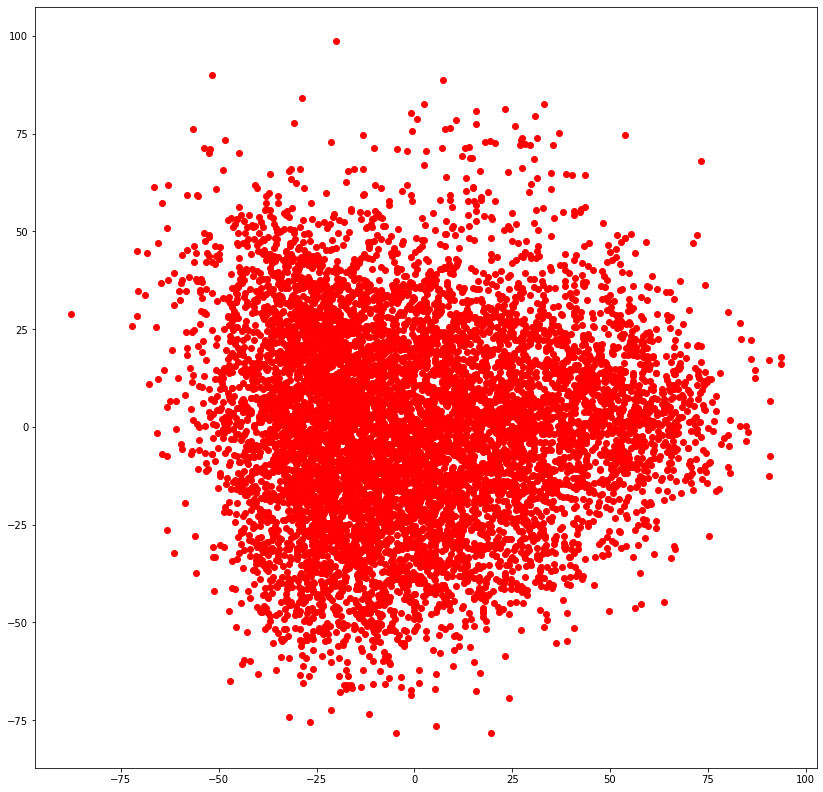

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,14))

im = read_image('/home/jafar/Downloads/data/img/42953.png')
im = np.array(im)
imcopy = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_AREA)
v = get_vector(imcopy.reshape((1, 224, 224, 3)))

v = pca.transform(v)
plt.scatter(v[:,0],v[:,1],c='b')

plt.scatter(zbr[:,0],zbr[:,1],c='r')
print(v[0],zbr[0])
plt.show()

[-0.86715684] [33.54294949]


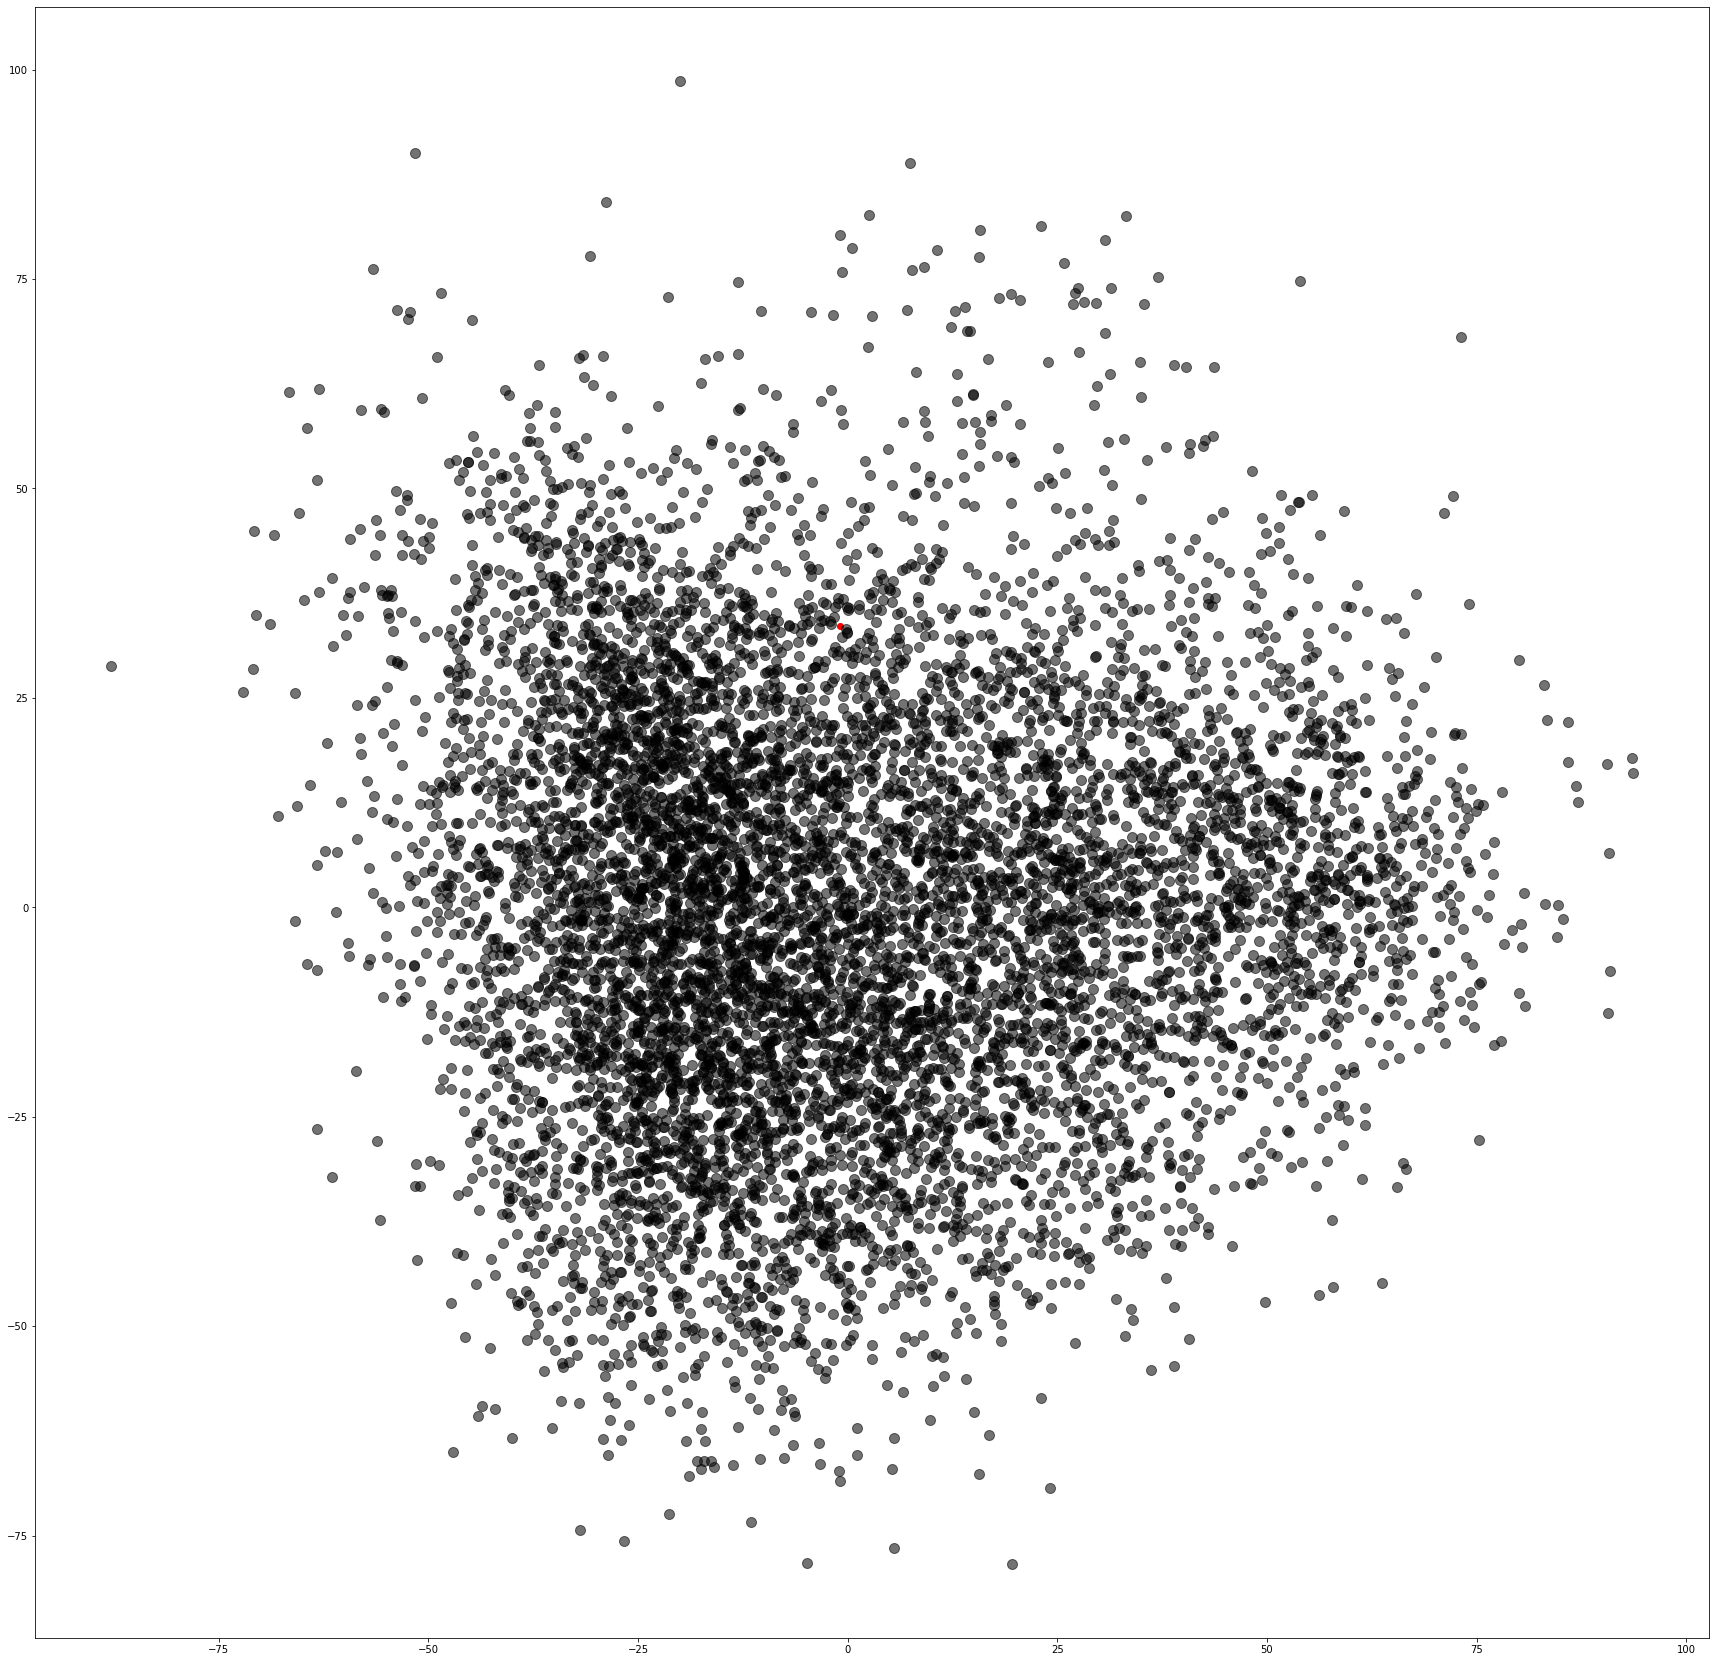

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,30))

im = read_image('./test/1.jpg')
im = np.array(im)
imcopy = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_AREA)
vc = image2np(imcopy)
vc2= get_vector(vc.reshape((1, 224, 224, 3)))

vc = base_model.predict(vc)
ks = vc.reshape(-1, 62720)

v = pca.transform(ks)
plt.scatter(v[:,0],v[:,1],c='r')

plt.scatter(zbr[:,0],zbr[:,1],facecolors='black',alpha=.55, s=100)
print(v[:,0],v[:,1])
plt.show()



0.0

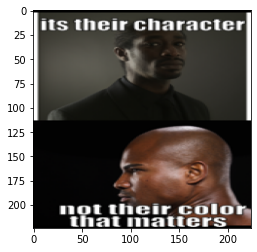

In [56]:
meme_index, id2json_indexer = get_indexes()
zbr = read_image(DATASET_PATH + '/' + id2json_indexer[42953][0]['img'])
zbr = np.array(zbr)
result = cv2.resize(zbr, dsize=(224, 224), interpolation=cv2.INTER_AREA)
result = image2np(result)

plt.imshow(result[0,:,:,:])
ks =  base_model.predict(result)

ks = ks.reshape(-1, 62720)

(ks - images[0]).min()


In [20]:
images[1].max(), images[1].min(), images[1].std()

(12.422160148620605, -0.27846458554267883, 0.794970629791107)

In [16]:
id2json_indexer.keys()

dict_keys([42953, 23058, 13894, 37408, 82403, 16952, 76932, 70914, 2973, 58306, 79351, 34096, 25489, 19324, 79346, 13426, 97628, 14238, 28936, 59784, 2146, 70146, 28061, 97180, 49752, 25610, 15872, 72640, 64318, 17956, 93547, 10743, 37091, 25719, 76825, 72598, 43078, 51846, 1569, 95812, 6418, 53976, 70193, 60427, 78395, 4876, 92075, 86354, 74386, 59613, 10263, 48279, 52610, 58371, 27401, 89574, 25473, 47913, 8295, 2497, 90471, 69357, 54602, 15320, 63182, 20619, 82457, 81059, 42137, 74530, 40832, 46127, 87594, 12548, 12894, 2476, 6937, 5762, 40259, 85072, 46537, 56432, 39805, 29163, 36072, 60147, 90583, 38612, 52097, 34961, 15803, 89762, 38465, 53289, 75321, 18350, 91547, 30247, 93741, 51243, 5384, 1845, 34791, 41385, 34508, 80521, 34165, 93072, 25468, 9617, 96258, 96578, 35618, 5249, 57349, 78409, 29814, 20568, 84269, 68079, 41537, 12890, 54102, 63217, 3271, 35264, 63710, 12348, 14052, 81064, 74391, 36152, 80256, 21948, 70532, 25806, 26759, 27398, 18730, 75216, 91754, 42153, 83456, 186

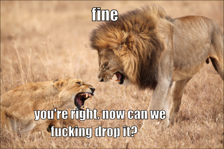

In [30]:
read_image(DATASET_PATH + '/' + id2json_indexer[76932][0]['img'])

In [1]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)
images = np.load('DataCleaner/extracted_features1.npy')
pca.fit(images)

PCA(n_components=2)

In [2]:
zbr = pca.transform(images)



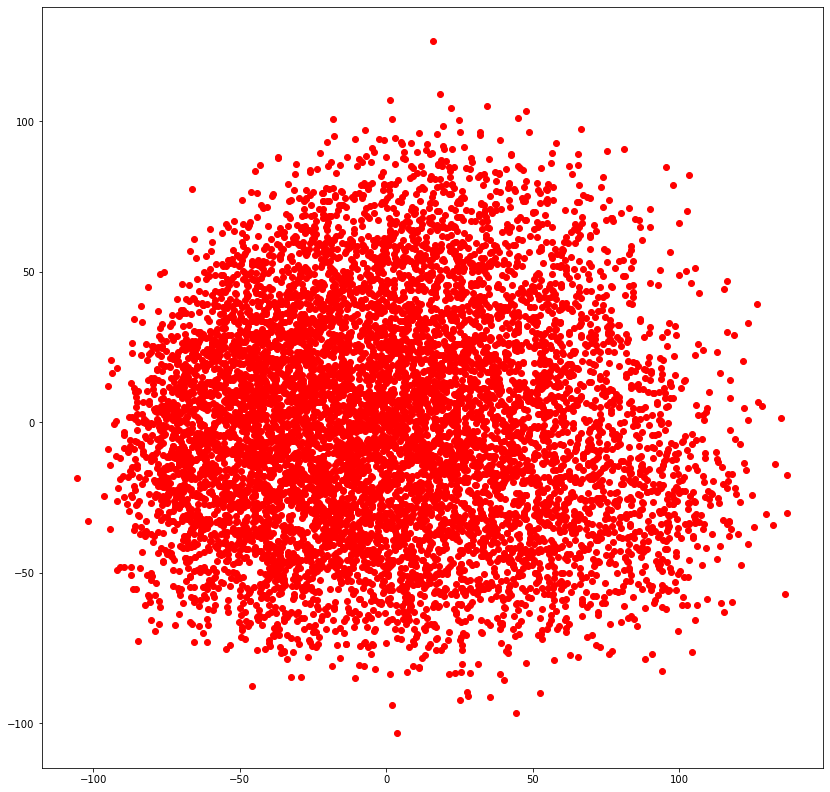

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,14))

plt.scatter(zbr[:,0],zbr[:,1],c='r')
plt.show()